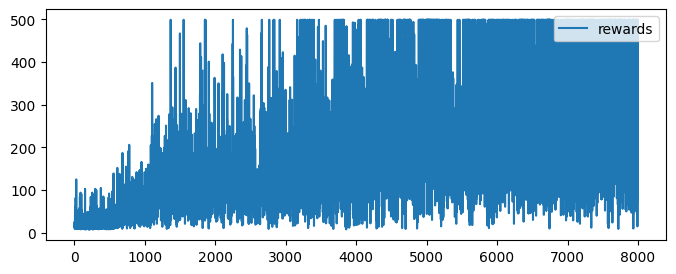

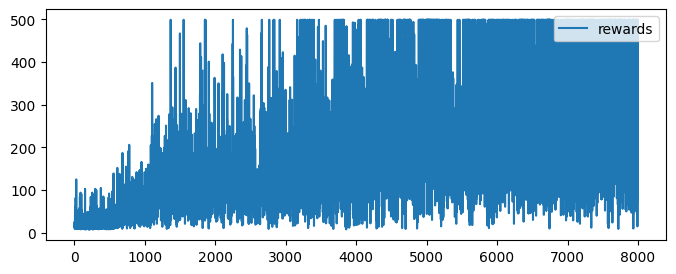

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import random

from tqdm.notebook import tqdm
import gymnasium as gym

from utils import digitize, get_bins

# policy is epsilon-greedy with respect to Q.
def policy(epsilon, Q, bins, observation):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, Q.shape[-1] - 1)  # right bound is included
    
    p, pv, a, av = digitize(observation, bins)
    return np.argmax(Q[p, pv, a, av, :])

def q_learning(n_episodes):
    env = gym.make('CartPole-v1', render_mode="rgb_array")

    # initialize Q table
    n_actions = env.action_space.n
    # define bins for the continuous observations.
    bin_size = 30
    bins = get_bins(bin_size)
    Q = np.random.uniform(size=[bin_size]*len(bins) + [n_actions]) 
    # question: no need to set terminal states to 0?

    # t used to set learning rate alpha = 1/t
    t = 1
    gamma = 0.995

    # Initialize metrics to monitor learning progress.
    rewards = []
    plt.ion()
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 3))
    # Initialize line object and legend
    [line] = ax.plot([], [], label="rewards")
    ax.legend(loc="upper right")

    for i in tqdm(range(n_episodes)):
        # epsilon = 1/(i+1)?
        policy_fn = lambda obs: policy(epsilon=0.2, Q=Q, bins=bins, observation=obs)
        # run episode.
        obs, info = env.reset()
        done = False
        curr_returns = 0
        while not done:
            alpha = 0.1
            action = policy_fn(obs)
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if done:
                break

            p, pv, a, av = digitize(obs, bins)
            pn, pvn, an, avn = digitize(new_obs, bins)
            q1 = Q[p, pv, a, av, action]
            q2 = Q[pn, pvn, an, avn, :].max()
            #new_action = policy_fn(new_obs)
            #q2 = Q[pn, pvn, an, avn, new_action]
            Q[p, pv, a, av, action] = q1 * (1 - alpha) + alpha * (reward + gamma * q2) 
            curr_returns += reward
            t += 1
            obs = new_obs

        # update plot.
        rewards.append(curr_returns)
        line.set_data(range(len(rewards)), rewards)
        ax.relim()  # Recalculate limits
        ax.autoscale_view(True,True,True)  # Rescale the axis
        clear_output(wait=True)  # Clear the output
        display(fig)  # Re-display the figure

    env.close() 
    plt.ioff()
    return Q

Q = q_learning(n_episodes=8000)

In [3]:
from utils import sample_episode

# save gif.
env = gym.make("CartPole-v1", render_mode="rgb_array")
_ = sample_episode(
    lambda obs: policy(epsilon=0., Q=Q, bins=get_bins(bin_size=30), observation=obs), 
    env=env,
    render=True
)
env.close()